In [158]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import torch
import torch.nn
import torch.optim 

In [159]:
import torch
import torch.nn as nn
import torch.optim as optim

# Sample data (use your own)
# t: shape (N, 1), targets: shape (N, 2)
t = torch.linspace(0, 2, steps=100).unsqueeze(1)  # (100, 1)
v0x, v0y, g = 5.0, 10.0, 9.8
sx = v0x * t
sy = v0y * t - 0.5 * g * t ** 2
targets = torch.cat([sx, sy], dim=1)  # (100, 2)

In [183]:
model = torch.nn.Sequential(
    torch.nn.Linear(1, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 2)
)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.01)

for epoch in range(500):
    optimizer.zero_grad()
    outputs = model(t)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

In [184]:
preds = model(t).detach().numpy()

In [185]:
sorted_indices = torch.argsort(t.squeeze())

In [186]:
pred_x = outputs[sorted_indices, 0] 
pred_y = outputs[sorted_indices, 1]

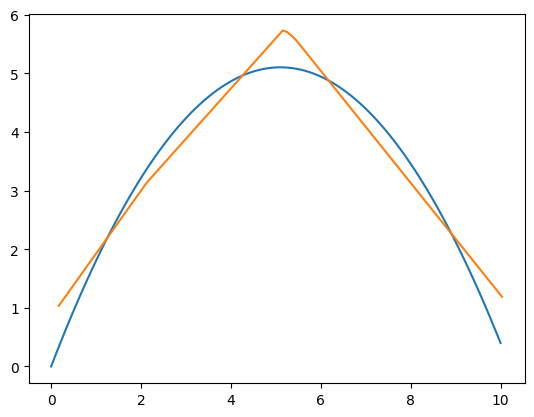

In [187]:
plt.plot(sx, sy)
plt.plot(pred_x.detach(), pred_y.detach())

# Coffee Cup example

In [263]:
T_env = 90
T_0 = 150
r = .5

def f(t,T):
    return .05*(T_env - r)

def T(t):
    return (T_0 - T_env)*np.exp(-r*t) + T_env

time_space = np.linspace(start=0, stop=10, num=1000)
t_given = time_space[:100]
T_true = np.array([T(t) for t in time_space])
T_given = np.array([T(t) for t in t_given])

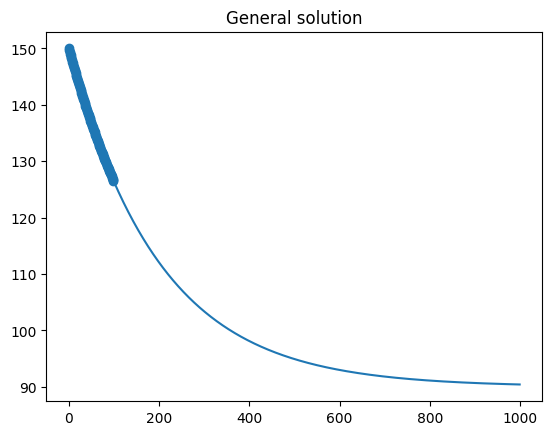

In [264]:
plt.plot(T_true)
plt.title("General solution")
plt.scatter(x=[t_given*100], y=T_given, marker='o')

In [283]:
torch.tensor(t_given).float().reshape(100,1)

tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400],
        [0.0501],
        [0.0601],
        [0.0701],
        [0.0801],
        [0.0901],
        [0.1001],
        [0.1101],
        [0.1201],
        [0.1301],
        [0.1401],
        [0.1502],
        [0.1602],
        [0.1702],
        [0.1802],
        [0.1902],
        [0.2002],
        [0.2102],
        [0.2202],
        [0.2302],
        [0.2402],
        [0.2503],
        [0.2603],
        [0.2703],
        [0.2803],
        [0.2903],
        [0.3003],
        [0.3103],
        [0.3203],
        [0.3303],
        [0.3403],
        [0.3504],
        [0.3604],
        [0.3704],
        [0.3804],
        [0.3904],
        [0.4004],
        [0.4104],
        [0.4204],
        [0.4304],
        [0.4404],
        [0.4505],
        [0.4605],
        [0.4705],
        [0.4805],
        [0.4905],
        [0.5005],
        [0.5105],
        [0.5205],
        [0.5305],
        [0.5405],
        [0

In [384]:
class PINNLoss(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def grad(self, outputs, inputs):
        return torch.autograd.grad(
            outputs=outputs,
            inputs=inputs,
            grad_outputs=torch.ones_like(outputs),
            create_graph=True, 
            retain_graph=True
        )[0]
    
    def physical_loss(self, model, ts):
        ts = ts.clone().detach().requires_grad_(True)
        inputs = ts
        outputs = model(ts)
        df_dt = self.grad(outputs=outputs, inputs=inputs)
        loss_term = df_dt - r*(T_env - outputs)
        return torch.mean(loss_term**2)
    
    def forward(self, model, ts, t_given, T_given):
        loss = torch.mean((model(t_given)[0] - T_0)**2) + self.physical_loss(model, ts)
        return loss

In [385]:
targets = T_given

model = torch.nn.Sequential(
    torch.nn.Linear(1, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 1)
)

criterion = PINNLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.01)

for epoch in range(500):
    optimizer.zero_grad()
    outputs = model(torch.tensor(t_given).float().reshape(100,1))
    loss = criterion(model=model,
                     ts=torch.tensor(time_space).float().reshape(1000,1),
                     t_given=torch.tensor(t_given).float().reshape(100,1),
                     T_given=T_given)
    loss.backward()
    optimizer.step()

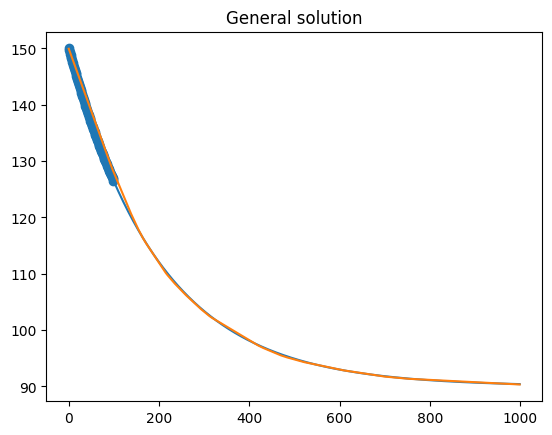

In [386]:
plt.plot(T_true)
plt.title("General solution")
plt.scatter(x=[t_given*100], y=T_given, marker='o')
plt.plot(model(torch.tensor(time_space).float().reshape(1000,1)).detach().numpy())